In [1]:
#Hilfsskripte
import Preprocessing_aux
from plotfunctions import *
from confidence_ellipse import *

#Basics
import numpy as np
import pandas as pd

#Visualistion
import matplotlib.pyplot as plt
import seaborn as sns

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

#Preprocessing
from scipy.signal import savgol_filter
from sklearn import svm
from sklearn.cluster import KMeans

In [2]:
#Read CSV File
file = "Data_3.csv"
rawberry = pd.read_csv(file, index_col=0).T

#Ectract Indexinformation
rawberry["Sample_Category"] = rawberry.index.str.strip(".1234567890").astype("category")

#Gererating index, dataset has none
sample_number = []
for i in range(1, 984):
    sample_number.append(i)
idx = pd.Index(sample_number, name="sample_number")

rawberry.set_index(idx, inplace=True)
rawberry.head()


Wavenumbers,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Sample_Category
sample_number,,,,,,,,,,,,,,,,,,,,,
1,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
2,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry
3,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007,NON-Strawberry
4,0.002345,0.002292,0.002249,0.002303,0.002466,0.002642,0.002703,0.002671,0.002618,0.002567,...,0.000419,0.000267,0.000179,0.000119,0.000075,0.000043,0.000021,0.000008,0.000008,NON-Strawberry
5,0.002303,0.002342,0.002350,0.002419,0.002561,0.002737,0.002862,0.002860,0.002811,0.002750,...,0.000468,0.000299,0.000212,0.000140,0.000099,0.000054,0.000020,0.000012,0.000012,NON-Strawberry


In [3]:
#keep relevant information
y = np.array(rawberry["Sample_Category"].values)
sample_numbers = np.array(list(rawberry.index))

#Wavenumbers for plotting, prevent using last column: is category --> -2
dim = np.array(rawberry.columns[:-2].values.astype(np.float64))
display(dim[:10])

#Spektrum
X = np.array(rawberry.iloc[:,:-2].values.astype(np.float64))
display(X.shape)

array([899.327, 903.187, 907.047, 910.907, 914.767, 918.627, 922.487,
       926.347, 930.207, 934.067])

(983, 234)

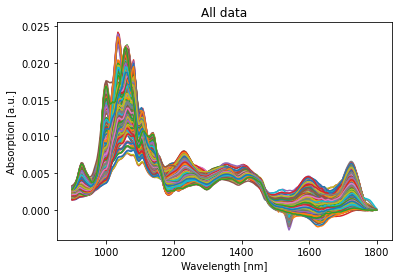

In [4]:
#Plotting of all data
def plotspec(X, dim, title= None):
    plt.figure()
    for i in range(len(X)):
        plt.plot(dim, X[i])
    
    plt.gca().set_title(title)

    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Absorption [a.u.]")
    plt.show()

plotspec(X,dim, "All data")

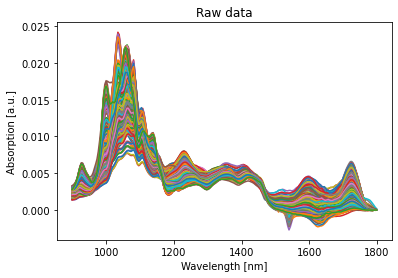

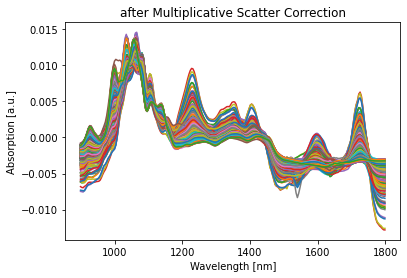

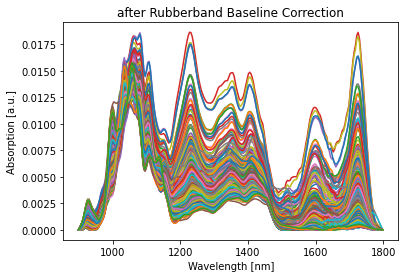

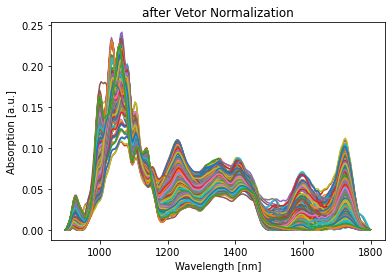

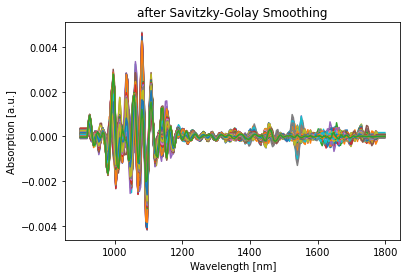

In [5]:
X_pre = X

plotspec(X_pre, dim, title='Raw data')
# Multiplicative Scatter Correction
X_pre = Preprocessing_aux.msc(X_pre)
plotspec(X_pre, dim, title='after Multiplicative Scatter Correction')



# Rubberband Baseline Correction
X_pre = Preprocessing_aux.rubberband(X_pre, dim)
plotspec(X_pre, dim, title='after Rubberband Baseline Correction')

#Normalize
X_pre = normalize(X_pre)  # from sklearn.preprocessing
plotspec(X_pre, dim, title='after Vetor Normalization')

# Savitzky-Golay Smoothing
w = 11 # window width
p = 4 # polynomial order
X_pre = savgol_filter(X_pre, w, polyorder = p, deriv=4)
plotspec(X_pre, dim, title='after Savitzky-Golay Smoothing')

<hr>
<h2>PCA</h2>

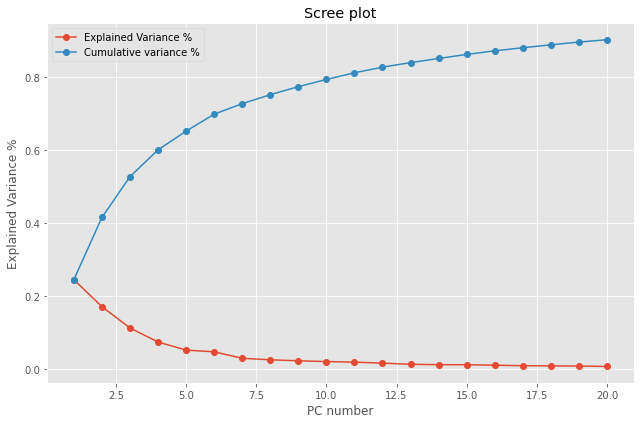

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cat
0,1.810187,13.607518,-1.874701,-1.356581,5.694871,-1.353027,6.230092,-3.608168,4.926885,3.103652,NON-Strawberry
1,-9.358227,-8.913366,-3.369365,-11.296083,1.515481,-4.353990,0.450020,-1.724594,-0.626007,-1.743103,NON-Strawberry
2,11.048773,7.950113,-4.479505,-0.699534,1.004247,-1.565602,4.454161,-3.690029,-0.733705,-1.305221,NON-Strawberry
3,-1.566424,6.393719,-4.503281,-0.611433,-0.092677,-0.004685,-1.402305,1.419713,-1.100282,-1.561491,NON-Strawberry
4,3.291475,7.139328,-5.364235,-2.115340,5.595214,-0.326132,2.735642,4.503120,1.550068,4.965427,NON-Strawberry


In [6]:
#Standard Scaling
X_scaled = StandardScaler().fit_transform(X_pre)

#ScreePlot
PCA_V = PCA(n_components = 20).fit(X_scaled)
scree_plot(PCA_V)
plt.show()

#Scores
scores = PCA(n_components=10).fit_transform(X_scaled)

df = pd.DataFrame(scores)
df.columns = (("PC"+ str(i+1)) for i in range(10))
df["cat"] = y
df.head()

In [7]:
#Try and Run Plotting, all PCs

# for i in range(10):
#     for n in range(10):
#         if i ==n:
#             continue
#         else:
#             sns.scatterplot(data = df, x = df.iloc[:,i], y=df.iloc[:,n], hue ="cat")
#             plt.show()


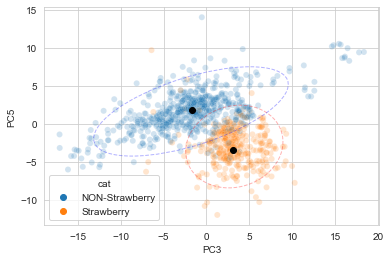

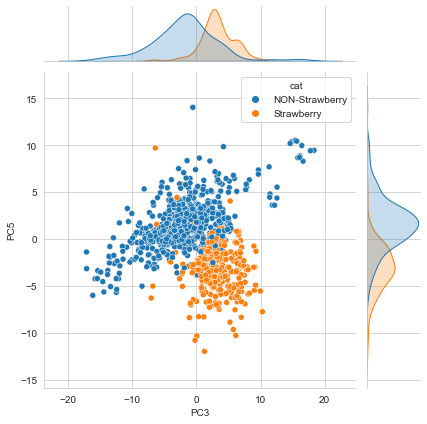

In [8]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()
df_straw= df[df["cat"] == "Strawberry"]
df_non_straw= df[df["cat"] != "Strawberry"]

#ScatterPlot with Confidence Intervals
sns.scatterplot(data = df, x = df.iloc[:, 2], y = df.iloc[:, 4], hue = "cat", alpha = 0.2)
confidence_ellipse_interv(x= df_straw["PC3"], y=df_straw["PC5"], ax= ax, facecolor='none', conf_interv="90", edgecolor = "red", linestyle="--")
confidence_ellipse_interv(x= df_non_straw["PC3"], y=df_non_straw["PC5"], ax= ax, facecolor='none', conf_interv="90", edgecolor = "blue", linestyle="--")

#Display Centroids
plt.plot(-1.722958,1.879614, "o", color = "black") 
plt.plot(3.102306	,-3.384376,"o", color = "black") 
#JointPlot
sns.jointplot(data = df, x = df.iloc[:, 2], y = df.iloc[:, 4], hue = "cat", kind = "scatter")

<hr>
<h2>Mahalanobis Distance - Model, simplified</h2>


$
MD = \sqrt{ \left(\begin{array}{c} x - \bar{x} \\ y - \bar{y} \end{array}\right)^{T} S^{-1} \left(\begin{array}{c} x- \bar{x} \\ y -\bar{y} \end{array}\right)}
$

In [9]:
centroid = df.groupby("cat")[["PC3", "PC5"]].mean()
centroid

,PC3,PC5
cat,,
NON-Strawberry,-1.802249,1.649442
Strawberry,3.245075,-2.969935


In [10]:
def compute_MD(x_data, y_data, S, to="straw"):
    """computes Mahalanobis Distance from given Datapoints in 2 dimensional space

        Parameters
        to: string
            MD towards which Centroid
        x_data: float
            x-Datapoint
        y_data: float
            y-Datapoint
        S:  np.array
            Covarianz matrix       
    """
    if to == "straw":
        x_mu = centroid.iloc[1,0]
        y_mu = centroid.iloc[1,1]
    else:
        x_mu = centroid.iloc[0,0]
        y_mu = centroid.iloc[0,1]


    A = np.array([[x_data - x_mu], [y_data - y_mu]])
    A_T= A.transpose()

    S_invers = np.linalg.inv(S)

    MD =np.sqrt(A_T @ S_invers @ A)
    return MD

In [11]:
MD_to_straw=[]
MD_to_non_straw=[]

x_y_zipped = list(zip(df["PC3"], df["PC5"]))
for tp in x_y_zipped:
    MD = compute_MD(x_data = tp[0], y_data=tp[1], S =np.cov(df["PC3"], df["PC5"]), to = "straw")
    MD_to_straw.append(MD.round(decimals = 4))
for tp in x_y_zipped:
    MD = compute_MD(x_data = tp[0], y_data=tp[1], S =np.cov(df["PC3"], df["PC5"]), to = "non")
    MD_to_non_straw.append(MD.round(decimals = 4))

df["MD_to_straw"] = MD_to_straw
df["MD_to_non_straw"] = MD_to_non_straw
df["MD_to_straw"] = df["MD_to_straw"].astype(float)
df["MD_to_non_straw"] = df["MD_to_non_straw"].astype(float)


Prediction = []
for lab, row in df.iterrows():
    if row["MD_to_non_straw"] > row["MD_to_straw"]:
        Prediction.append("Strawberry")
    else:
        Prediction.append("NON-Strawberry")

df["Prediction"] = Prediction


Validation = []
for lab, row in df.iterrows():
    if row["cat"]== row["Prediction"]:
        Validation.append(True)
    else:
        Validation.append(False)
df["Validation"] = Validation
df.sample(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cat,MD_to_straw,MD_to_non_straw,Prediction,Validation
413,-1.986293,1.047971,6.993556,-1.512437,-8.336326,-0.489630,-6.173285,0.101274,-4.056824,-5.308997,Strawberry,1.7129,3.3548,Strawberry,True
228,-6.957689,2.499227,-2.817737,-3.407554,3.024769,0.783716,8.191595,11.568963,-5.305106,0.653184,NON-Strawberry,2.0963,0.4437,NON-Strawberry,True
471,-2.386283,-6.570389,-0.564107,-12.493404,2.801127,8.877082,-1.000224,-2.752308,2.658060,-1.259541,NON-Strawberry,1.8240,0.4110,NON-Strawberry,True
341,1.717986,7.569148,-4.758566,-0.510056,-1.559886,-1.592535,2.012204,-1.866593,-0.438617,-4.338130,NON-Strawberry,1.6150,1.0914,NON-Strawberry,True
970,-6.647607,-0.601426,15.804118,18.446581,8.665344,3.041425,-1.674824,-0.507271,-1.210459,-0.231276,NON-Strawberry,4.1580,3.9899,NON-Strawberry,True


<h2 id="Validation">Validation</h2>

In [12]:
df["Validation"].value_counts(normalize = True)

True     0.933876
False    0.066124
Name: Validation, dtype: float64

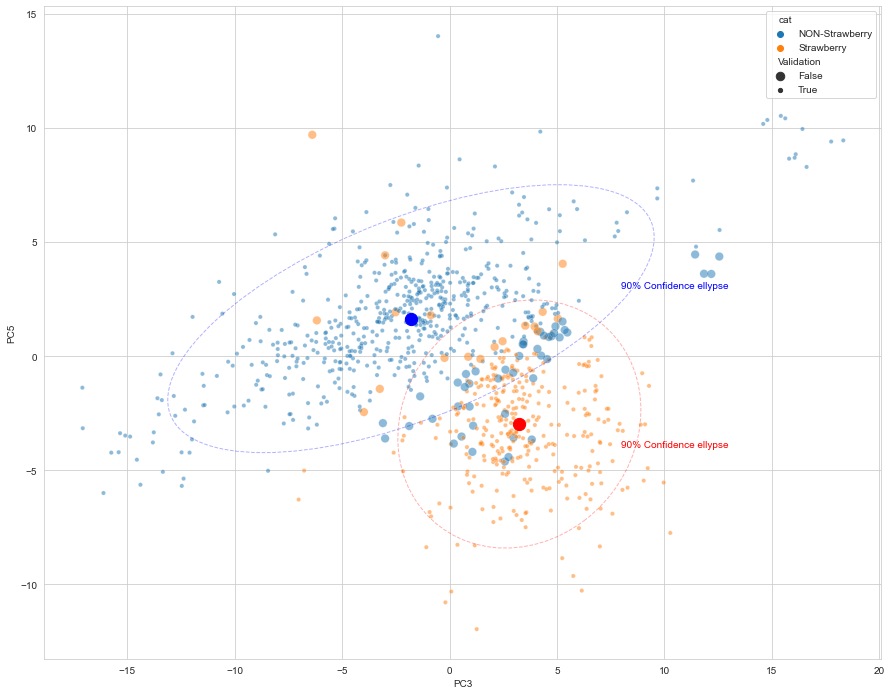

In [13]:
fig, ax = plt.subplots(figsize=(15,12))
sns.scatterplot(data = df, x = "PC3", y = "PC5", hue= "cat", size = "Validation", alpha = 0.5)
#Display 90% confidense ellypses
confidence_ellipse_interv(x= df_straw["PC3"], y=df_straw["PC5"], ax= ax, facecolor='none', conf_interv="90", edgecolor = "red", linestyle="--")
confidence_ellipse_interv(x= df_non_straw["PC3"], y=df_non_straw["PC5"], ax= ax, facecolor='none', conf_interv="90", edgecolor = "blue", linestyle="--")
ax.annotate("90% Confidence ellypse", xy= (8,3), color = "blue")
ax.annotate("90% Confidence ellypse", xy= (8,-4), color = "red")

#Display Centroids
plt.scatter(centroid.iloc[0,0], centroid.iloc[0,1], color = "blue", s = 150) 
plt.scatter(centroid.iloc[1,0], centroid.iloc[1,1], color = "red", s = 150) 


In [15]:
#Export Loadings
loadings = pd.DataFrame(PCA_V.components_.T)
with open("Transfer/loadings_pca_new.csv", "w") as csvfile:
    loadings.to_csv(csvfile, sep=",")

#Export Scores
scores = pd.DataFrame(scores)
with open("Transfer/scores_pca_new.csv", "w") as csvfile:
    scores.to_csv(csvfile, sep=",")
scores.shape

#Export X_scaled
X_scaled = pd.DataFrame(X_scaled)
with open("Transfer/x_scaled_new.csv", "w") as csvfile:
    X_scaled.to_csv(csvfile, sep=",")

<a href="strawberries_deriv3_PC3und4.ipynb">Link back to deriv3_PC3and4</a>